# <font color='blue'>**LABORATORIO 2. Clasificación de imágenes usando CNN's**


Estudiar las Redes Neuronales Convolucionales (CNN) es beneficioso por varias razones:

* **Excelente Desempeño en Imágenes**: Las CNN han demostrado un rendimiento excepcional en tareas de visión computacional debido a su capacidad para capturar patrones locales y globales en imágenes.

* **Eficiencia en Términos de Parámetros**: Las CNN están diseñadas para aprovechar la estructura de las imágenes, utilizando capas convolucionales que comparten parámetros. Esto las hace mucho más eficientes en términos de la cantidad de parámetros requeridos en comparación con una red neuronal *FULLY CONNECTED*.

* **Invariancia a Traslaciones**: Las capas convolucionales permiten a las CNN aprender características invariantes a pequeñas traslaciones. Esto significa que la red puede reconocer patrones incluso si están ubicados en diferentes partes de una imagen.

* **Capacidad de Aprendizaje Jerárquico**: Las CNN tienen múltiples capas convolucionales y de agrupación que les permiten aprender características a diferentes niveles de abstracción. Las primeras capas pueden aprender bordes y texturas simples, mientras que las capas más profundas pueden aprender características más complejas y abstractas.

* **Transferencia de Conocimiento**: Las CNN entrenadas en grandes conjuntos de datos, como ImageNet, pueden ser utilizadas como puntos de partida para tareas de clasificación específicas. Esto se conoce como transferencia de conocimiento y puede ahorrar mucho tiempo y recursos en el entrenamiento de modelos.

* **Interpretabilidad Relativa**: Aunque las CNN no son tan interpretables como algunos otros modelos más simples, como árboles de decisión, se han desarrollado técnicas y herramientas para ayudar a comprender qué características están siendo detectadas por diferentes capas de la red.

Siga las instrucciones (<font color='red'>resaltadas en rojo </font>), las cuales además de guiarlo, generarán en suma el puntaje final obtenido para este laboratorio.

# Importación de librerias y dataset

In [ ]:
#Para dar un orden al trabajo realizado, coloque aqui todas las librerias que van a ser usadas.
from google.colab import files
import os
import numpy as np
from matplotlib import pyplot as plt
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santiagoam2800","key":"8736a4fff615e1fa8f9309449e4309d7"}'}

In [ ]:
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset
License(s): other
 96% 233M/242M [00:02<00:00, 92.7MB/s]
100% 242M/242M [00:02<00:00, 84.8MB/s]


In [ ]:
# Descomprimir el dataset descargado
with zipfile.ZipFile('/content/5-flower-types-classification-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset-name')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# <font color='red'>Punto 1 (1.0). Preprocesamiento</font>.

El pre-procesamiento de imagenes es una tarea fundamental cuando se desea que la IA trabaje correctamente.

(a) (0.25) Realice un código que le permita mostrar 5 imagenes por cada categoría seleccionadas del dataset.

(b) (0.25) Aunque el dataset ya se encuentra dividido en TRAIN y TEST, a partir del análisis visual realizado en el punto (a), usted deberá tomar la decisión acerca de trabajar el entrenamiento con todo el conjunto de imagenes dadas en TRAIN o con un subconjunto del mismo. Por otro lado usted deberá separar el 10% de las imagenes de TEST y dejarlas como una nueva carpeta de VALIDATION.

(c) (0.5) Realice un código que le permita pre-procesar el dataset. <font color='red'>Si usted decide no hacer ningun tipo de pre-procesamiento, usted deberá explicar claramente el porque usted consideró no necesario realizar este paso.



El pre procesamiento que se le hicieron a los datos es el recomendado por la arquitectura de pytorch, donde le aplicamos un resize a las imagenes de 224, 244, ademas que convertirlos a un tensor y por ultimo aplicar una normalizacion de la media y la desviacion estandar del canal de las dimensiones


In [ ]:
import numpy as np
import os
from PIL import Image

# Inicializar variables para almacenar la suma de los píxeles y suma de cuadrados de cada canal
means = np.zeros(3)
stds = np.zeros(3)
n_pixels = np.zeros(3)
data_dir = "/content/dataset-name/flower_images"

# Recorrer todos los subdirectorios y archivos dentro del directorio principal
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(root, filename)
            img = Image.open(img_path).convert('RGB')  # Abrir la imagen y convertirla a RGB
            img = np.array(img, dtype=np.float32) / 255.0  # Convertir a float32 y normalizar a [0, 1]

            for channel in range(3):
                channel_pixels = img[..., channel]
                means[channel] += np.sum(channel_pixels)
                stds[channel] += np.sum(channel_pixels ** 2)
                n_pixels[channel] += channel_pixels.size

# Calcular la media y desviación estándar final
means /= n_pixels
stds = np.sqrt(stds / n_pixels - means ** 2)

print("Media:", means)
print("Desviación Estándar:", stds)



Media: [0.55283441 0.51248248 0.44533421]
Desviación Estándar: [0.34790379 0.31921432 0.35787864]


In [ ]:
#Pegue y ejecute  aquí el código para el punto 1a.
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.55283441, 0.51248248, 0.44533421],[0.34790379, 0.31921432, 0.35787864])
])
# Cargar el dataset
dataset = datasets.ImageFolder(root='/content/dataset-name/flower_images', transform=data_transforms)

class_names = dataset.classes
print(class_names)

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [ ]:
#Pegue y ejecute aquí el código para el punto 1b.
train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

print(f"Tamaño del entrenamiento: {train_size} ")
print(f"Tamaño del testeo: {test_size}")
print(f"Tamaño del validacion: {val_size}")

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

batch_size = 64
learning_rate = 0.01
num_epochs = 40

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

Tamaño del entrenamiento: 3499 
Tamaño del testeo: 999
Tamaño del validacion: 501


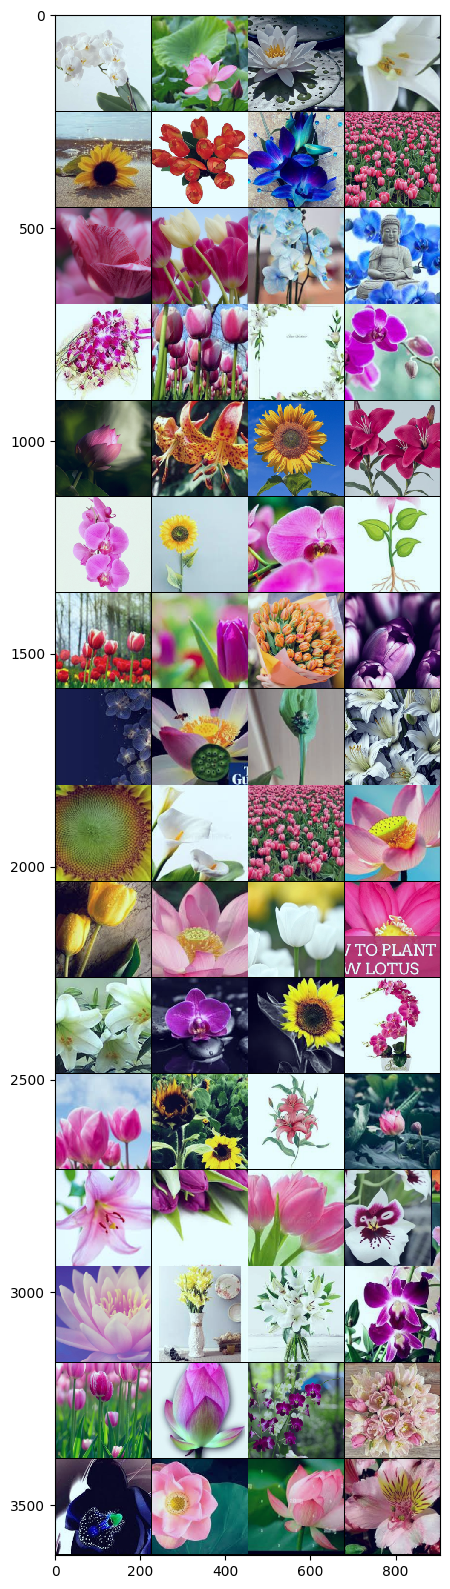

Etiquetas: tensor([2, 1, 1, 0, 3, 4, 2, 4, 4, 4, 2, 2, 2, 4, 0, 2, 1, 0, 3, 0, 2, 3, 2, 0,
        4, 4, 4, 4, 2, 1, 0, 0, 3, 0, 4, 1, 4, 1, 4, 1, 0, 2, 3, 2, 4, 3, 0, 1,
        0, 4, 4, 2, 1, 0, 0, 2, 4, 1, 2, 4, 2, 1, 1, 0]) [['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']]


In [ ]:
# Función para visualizar una imagen
def show_image(img):
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# Visualizar algunas muestras del conjunto de entrenamiento
batch_iterator = iter(train_loader)
images_train, labels_train = next(batch_iterator)

# Mostrar las imágenes
img_grid = vutils.make_grid(images_train, nrow=4, padding=2, normalize=True)
show_image(img_grid)
print('Etiquetas:', labels_train, [class_names])

In [ ]:
print(images_train.shape)

torch.Size([64, 3, 224, 224])


### Creacion del modelo que se va a utilizar

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):  #Se crea la capa de los bloques basicos que se van a usar
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Definimos la arquitectura de ResNet-18
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) # Primera capa
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0]) # Se pasa
        self.layer2 = self._make_layer(block, 256, layers[1], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)


        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

#### Modelos

In [ ]:
# Definimos la función para construir ResNet-18
def resnet18(num_classes=5):
    return ResNet(BasicBlock, [2, 2], num_classes).to(device)

# Creando una instancia de ResNet-18
resnet_no = resnet18(num_classes=5)
print(resnet_no)

criterion_no = nn.CrossEntropyLoss()
optimizer_no = torch.optim.SGD(resnet_no.parameters(), lr=learning_rate)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Definimos la función para construir ResNet-18
def resnet18(num_classes=5):
    return ResNet(BasicBlock, [2, 2], num_classes).to(device)

# Creando una instancia de ResNet-18
resnet_1 = resnet18(num_classes=5)
print(resnet_1)

criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(resnet_1.parameters(), lr=learning_rate, weight_decay=0.001)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Definimos la función para construir ResNet-18
def resnet18(num_classes=5):
    return ResNet(BasicBlock, [2, 2], num_classes).to(device)

# Creando una instancia de ResNet-18
resnet_2 = resnet18(num_classes=5)
print(resnet_2)

criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(resnet_2.parameters(), lr=learning_rate, weight_decay=0.01)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Definimos la función para construir ResNet-18
def resnet18(num_classes=5):
    return ResNet(BasicBlock, [2, 2], num_classes).to(device)

# Creando una instancia de ResNet-18
resnet_3 = resnet18(num_classes=5)
print(resnet_3)

criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.SGD(resnet_3.parameters(), lr=learning_rate, weight_decay=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# <font color='red'>Punto 2 (1.0). Cree y entrene un modelo para clasificación usando COMO BASE una arquitectura de internet

(0.5) Utilice los conocimientos adquiridos para entrenar y validar su modelo. Usted deberá hacer uso de: Gráficas de Accuracy / Loss, MaAtriz de confusión y reporte de clasificación (F1-Score, Recall, Precision)

(0.5) Analice los resultados obtenidos con las diferentes herramientas, dando una explicación que incluya las difernetes métricas y que sean consecuentes con los reultados obtenidos.

En este Caso la arquitectura que se uso es la de Resnet-18.
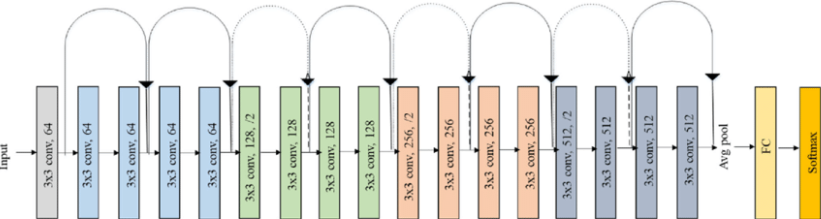
https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248

La imagen anterior es la arquitectura, donde tenemos que se basa en lo que seria un modelo de conexion por bloques residuales, estos bloques residuales tienen una conexion por skip, la cual ayuda a poder realizar un calculo mejor de lo que seria el calculo de los gradientes, ya que tiene dos caminos los cuales recorrer

Los diferentes modelos los cuales se crearon se hicieron con una metrica de regularizacion llamada weight decay es una técnica de regularización comúnmente utilizada en el entrenamiento de redes neuronales para prevenir el sobreajuste (overfitting). Funciona penalizando los pesos grandes en el modelo, lo que incentiva al modelo a aprender pesos más pequeños y, por lo tanto, a ser menos propenso a ajustarse demasiado a los datos de entrenamiento.

## Entrenamiento y validacion

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_correct = 0
        running_val_loss = 0.0
        running_val_correct = 0

        # Training loop
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_train_correct += (preds == labels).sum().item()

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Train Loss: {running_train_loss / (i + 1):.4f}')

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                running_val_correct += (preds == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_accuracy = running_train_correct / len(train_loader.dataset)
        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_accuracy = running_val_correct / len(val_loader.dataset)

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}')
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(range(num_epochs), train_losses, label='Train Loss')
    axs[0].plot(range(num_epochs), val_losses, label='Val Loss')
    axs[0].set_title('Losses')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    axs[1].plot(range(num_epochs), val_accuracies, label='Val Accuracy')
    axs[1].set_title('Accuracies')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def valid(modelo, criterion):
  total_loss = 0
  loss_values = []
  accuracy_values = []  # Lista para almacenar las precisiones por iteración
  total_correct_predictions = 0
  total_samples = 0

  # Listas para almacenar todas las etiquetas verdaderas y predicciones
  all_labels = []
  all_predictions = []

  # Evaluación del modelo
  with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = modelo(images)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          loss_values.append(loss.item())

          _, predicted = torch.max(outputs.data, 1)
          total_correct_predictions += (predicted == labels).sum().item()
          total_samples += labels.size(0)

          # Almacenar etiquetas y predicciones para métricas
          all_labels.extend(labels.cpu().numpy())
          all_predictions.extend(predicted.cpu().numpy())

          # Calcular precisión en esta iteración
          iteration_accuracy = (predicted == labels).sum().item() / labels.size(0)
          accuracy_values.append(iteration_accuracy)
  # Calcular pérdida y precisión promedio
  avg_loss = total_loss / len(val_loader)
  print(f"Promedio de pérdida en el conjunto de prueba: {avg_loss:.4f}")

  accuracy = total_correct_predictions / total_samples
  print(f"Precisión (accuracy) en el conjunto de prueba: {accuracy:.4f}")
  # Se imprimen 10 imagenes para poder ver como es su comparacion con la etiqueta y el valor predicho
  for j in range(10):
              plt.subplot(1, 2, 1)
              plt.imshow(images[j].cpu().permute(1, 2, 0))
              plt.axis('off')
              plt.title(f'Imagen {j+1}')

              plt.subplot(1, 2, 2)
              plt.text(0.1, 0.5, f'Predicción: {predicted[j].item()}', fontsize=12)
              plt.text(0.1, 0.3, f'Valor real: {labels[j].item()}', fontsize=12)
              plt.axis('off')

              plt.show()
  # Matriz de confusión
  conf_matrix = confusion_matrix(all_labels, all_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip'])
  disp.plot()
  plt.show()

  # Reporte de clasificación
  print("Reporte de Clasificación:\n", classification_report(all_labels, all_predictions, target_names=['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']))

  return conf_matrix

## Modelo de RES-NET 18 SIN REGULARIZACIÓN

Epoch [1/40], Step [10/55], Train Loss: 1.3736
Epoch [1/40], Step [20/55], Train Loss: 1.3177
Epoch [1/40], Step [30/55], Train Loss: 1.2717
Epoch [1/40], Step [40/55], Train Loss: 1.2359
Epoch [1/40], Step [50/55], Train Loss: 1.2108
Epoch [1/40], Train Loss: 1.2034, Train Accuracy: 0.5207, Val Loss: 1.1562, Val Accuracy: 0.5265
Epoch [2/40], Step [10/55], Train Loss: 1.0765
Epoch [2/40], Step [20/55], Train Loss: 1.0994
Epoch [2/40], Step [30/55], Train Loss: 1.0802
Epoch [2/40], Step [40/55], Train Loss: 1.0792
Epoch [2/40], Step [50/55], Train Loss: 1.0640
Epoch [2/40], Train Loss: 1.0600, Train Accuracy: 0.5810, Val Loss: 1.2566, Val Accuracy: 0.4965
Epoch [3/40], Step [10/55], Train Loss: 1.0245
Epoch [3/40], Step [20/55], Train Loss: 1.0009
Epoch [3/40], Step [30/55], Train Loss: 0.9900
Epoch [3/40], Step [40/55], Train Loss: 0.9993
Epoch [3/40], Step [50/55], Train Loss: 1.0014
Epoch [3/40], Train Loss: 0.9943, Train Accuracy: 0.6090, Val Loss: 1.1438, Val Accuracy: 0.6066
Epoc

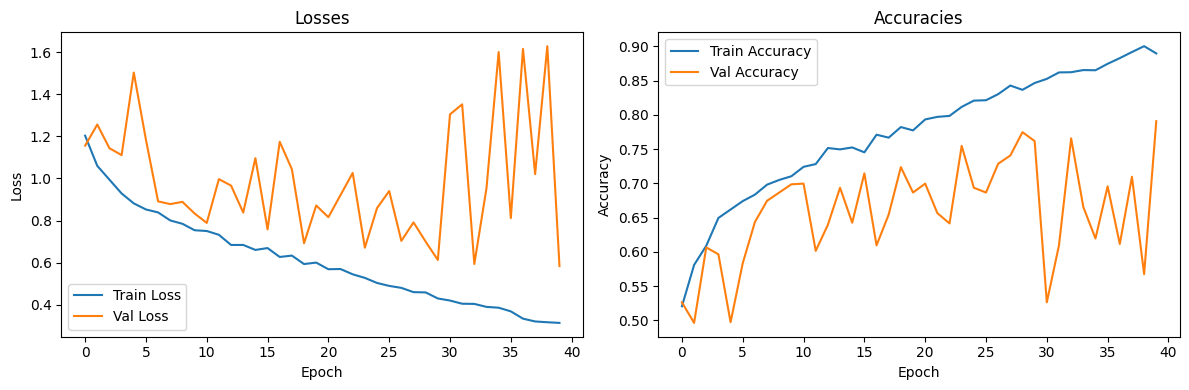

In [ ]:
model_no_train= train(resnet_no, criterion_no, optimizer_no, train_loader, test_loader, device)

Promedio de pérdida en el conjunto de prueba: 0.5833
Precisión (accuracy) en el conjunto de prueba: 0.7964


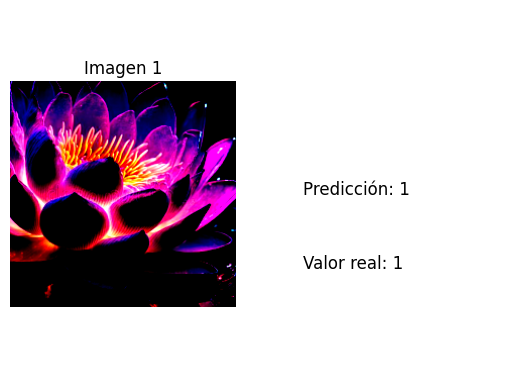

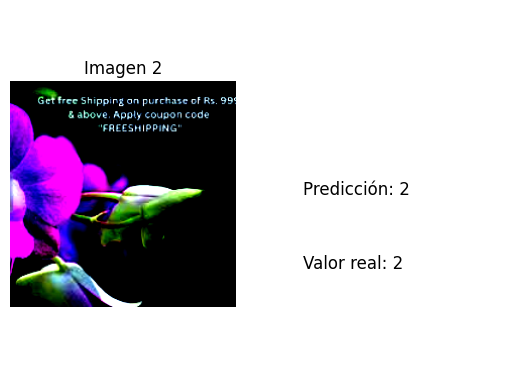

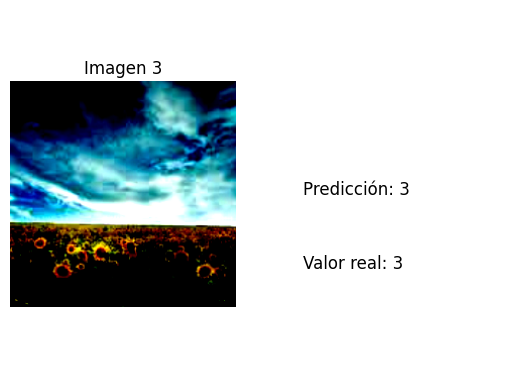

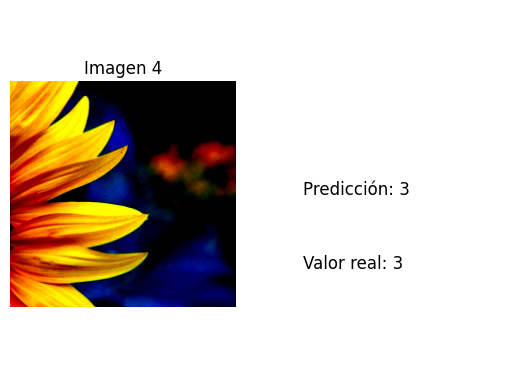

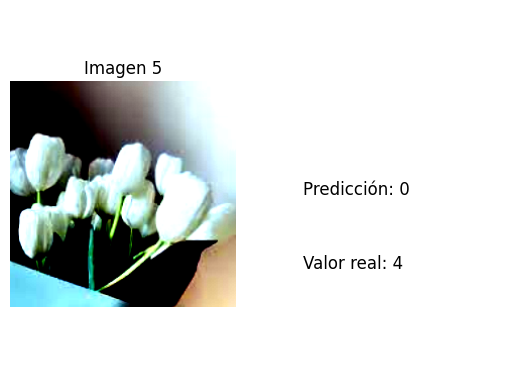

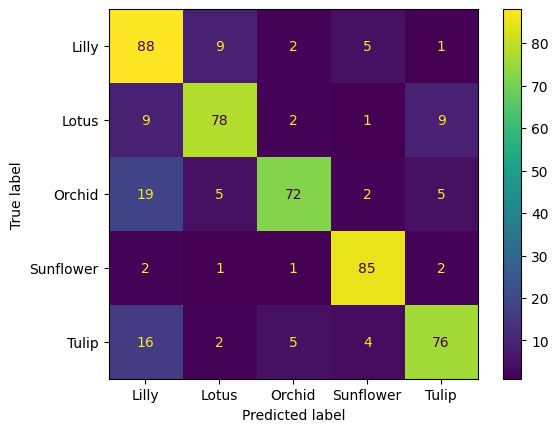

Reporte de Clasificación:
               precision    recall  f1-score   support

       Lilly       0.66      0.84      0.74       105
       Lotus       0.82      0.79      0.80        99
      Orchid       0.88      0.70      0.78       103
   Sunflower       0.88      0.93      0.90        91
       Tulip       0.82      0.74      0.78       103

    accuracy                           0.80       501
   macro avg       0.81      0.80      0.80       501
weighted avg       0.81      0.80      0.80       501



In [ ]:
model_no_testeo = valid(resnet_no,criterion_no)

Edite aquí el análisis para el punto 2.2

En el primer modelo realizado con un arquitectura RES-NET 18 y sin ningún regularizador, se obtuvieron primero las imágenes con su valor real y predicción y después los valores y gráficas para evaluar el rendimiento del modelo, como son sus gráficas de pérdida y de precisión y la matriz de confusión, presente a continuación:



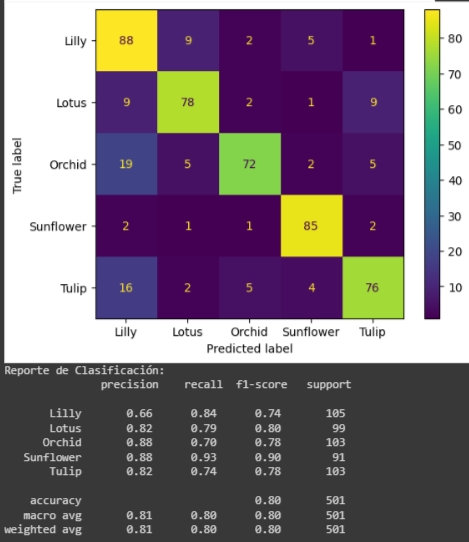

Con unos valores de pérdida y de precisión:
- Promedio de pérdida en el conjunto de prueba: 0.5833
- Precisión (accuracy) en el conjunto de prueba: 0.7964

La matriz de confusión nos da la evaluación requerida del modelo y ver su viabilidad y eficiencia en la labor que se requiere. Desglosando esta matriz, obtenemos que:
* En el momento en el que se hace el análisis con las imagenes de validacion se observa que todas estan se encuentran balanceadas, por lo que no hay problema en el momento de pensar en un posible sesgo que pueda presentar el modelo

* El accuracy global del modelo tiene un valor del  80%, mostrando en términos de porcentaje un valor elevado y una alta precisión del modelo en la clasificación.

* El f1-score el cuál es una métrica que combina la percisión y el recall, para obtener un valor mucho más objetivo en donde se visualiza que las 5 clases presentes presenten un valor de esta métrica por encima del 74%

* Las clases que presentaron una menor precisión y recall fueron:
    * La clase Lilly, presento una precisión del 66% y la clase Lotus y Tulip presento una precisión del 82%

    * La clase Lotus, Orchid, Tulip presentaron valores no tan elevados como los esperados en un rango superior al 85%, estos valores del recall fueron de: CLASE LOTUS obtuvo un recall de 79%, CLASE ORCHID obtuvo un recall de 70% y la clase Tulip obtuvo un recall de 74%, siendo los porcentajes más bajos de las 5 clases.

* Las clases que presentaron un mejor desempeño:
    * Las clases Orchid y Sunflower presentaron una precisión de 88%.

    * El mejor valor procentual del recall fue del 93% para la clase de Sunflower y le sigue la clase Lilly con un recall del 84%

    * La mejor clase del modelo que obtuvo los valores deseados o esperados para cada métrica (precisión, recall y f1-score) fue Sunflower con un valor de f1-score del 90%, siendo el valor de métrica más elevado por un 10% con la clase Lotus, además en las métricas de precision y recall obtuvo valores por encima del 87%, considerandose aceptables para clasificación

* De 105 datos para la clase **Lilly** el modelo clasifico adecuadamente como True Positive 88 de ellos, para la clase **Lotus** se tuvo 99 datos para ser clasificados de los cuales predijo bien el modelo un total de 78 datos. La clase **Orchid** tuvo un total de datos para predecir de 103, en donde el modelo predijo adecuadamente un total de 72, la mejor clase del modelo en clasificación **Sunflower** de 91 datos para que el modelo prediga, predijo correctamente un total de 85 datos mostrando la eficiencia del modelo para clasificar flores de la clase Sunflower. Por último, la clase **Tulip** de 103 datos, logró predecir adecuadamente TP un valor de 76 datos.

* La cantidad de epocas se ve reducia a 40, ya que el tiempo promedio en el cual se demora en correr un modelo es alrededor de 30 minutos, lo que hace que en momentos ocurran desconexiones, se cierre la sesion cuando ya los tiempos son muy extensos o se acababa la gpu T4.

# <font color='red'>Punto 3 (2.0). Usando métodos de regularización para mejorar el "***performance***" de su  modelo base.

(1.0) Usted podrá combinar diferentes métricas de regularización con el fin de obtener 3 modelos (**modelos regularizados**) que superen los resultados del modelo base.
<font color='red'> [Nota: Los 3 modelos deben mostrar graficos de Acurracy que corroboren la eliminación del overfitting. Tenga en cuenta además que los 3 modelos deberán mantener un Val-accuracy superior al 65%]

(0.25) Haciendo uso de transfer learning entrene un cuarto modelo. <font color='red'> [Nota: No olvide mostrar el grafico de Acurracy que corrobore la eliminación del overfitting y mantener un Val-accuracy superior al 65%]

(0.75) Realice un análisis comparativo de los resultados obtenidos con el mejor de los 3 modelos regularizados y el modelo 4.

## Modelo de RES-NET 18 CON REGULARIZACIÓN DE 0.001

Epoch [1/40], Step [10/55], Train Loss: 1.4367
Epoch [1/40], Step [20/55], Train Loss: 1.3226
Epoch [1/40], Step [30/55], Train Loss: 1.2775
Epoch [1/40], Step [40/55], Train Loss: 1.2362
Epoch [1/40], Step [50/55], Train Loss: 1.2141
Epoch [1/40], Train Loss: 1.1971, Train Accuracy: 0.5179, Val Loss: 1.1274, Val Accuracy: 0.5596
Epoch [2/40], Step [10/55], Train Loss: 1.1211
Epoch [2/40], Step [20/55], Train Loss: 1.0745
Epoch [2/40], Step [30/55], Train Loss: 1.0608
Epoch [2/40], Step [40/55], Train Loss: 1.0562
Epoch [2/40], Step [50/55], Train Loss: 1.0497
Epoch [2/40], Train Loss: 1.0482, Train Accuracy: 0.5970, Val Loss: 1.2193, Val Accuracy: 0.4935
Epoch [3/40], Step [10/55], Train Loss: 0.9791
Epoch [3/40], Step [20/55], Train Loss: 0.9771
Epoch [3/40], Step [30/55], Train Loss: 0.9883
Epoch [3/40], Step [40/55], Train Loss: 0.9861
Epoch [3/40], Step [50/55], Train Loss: 0.9898
Epoch [3/40], Train Loss: 0.9852, Train Accuracy: 0.6167, Val Loss: 1.1498, Val Accuracy: 0.5556
Epoc

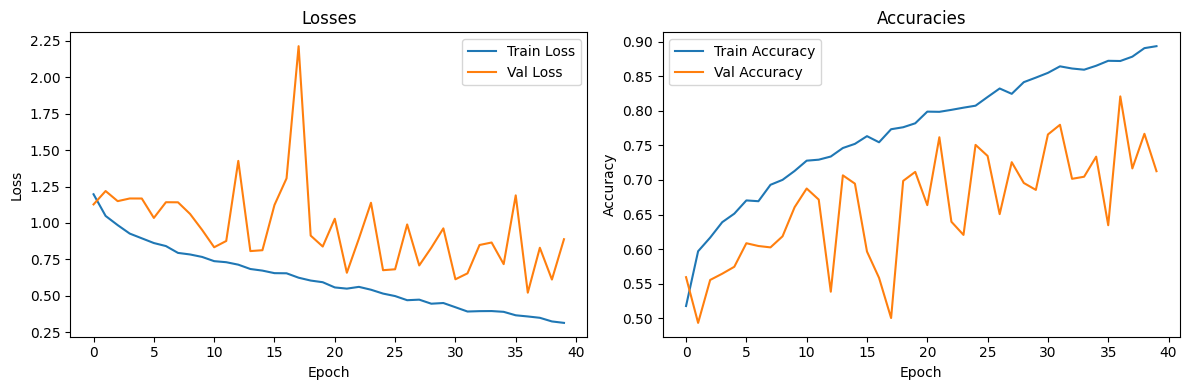

In [ ]:
#Pegue y ejecute aquí su código para el punto 3.1
modelo_1 = train(resnet_1, criterion_1, optimizer_1, train_loader, test_loader, device)

Promedio de pérdida en el conjunto de prueba: 0.9054
Precisión (accuracy) en el conjunto de prueba: 0.6946


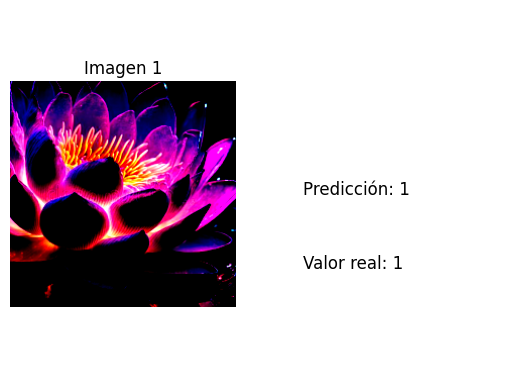

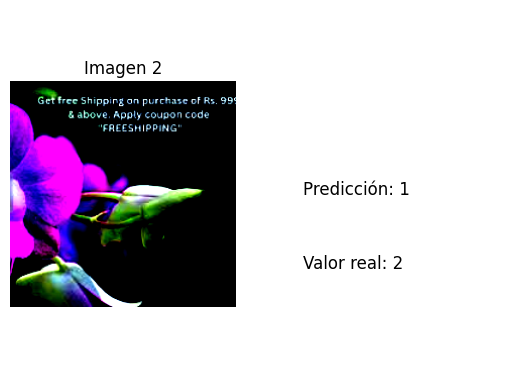

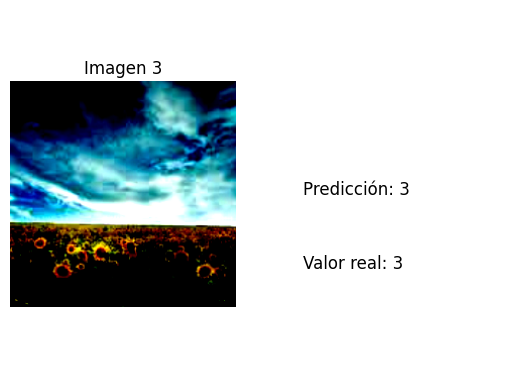

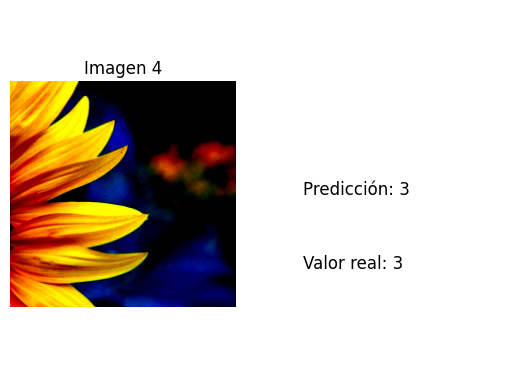

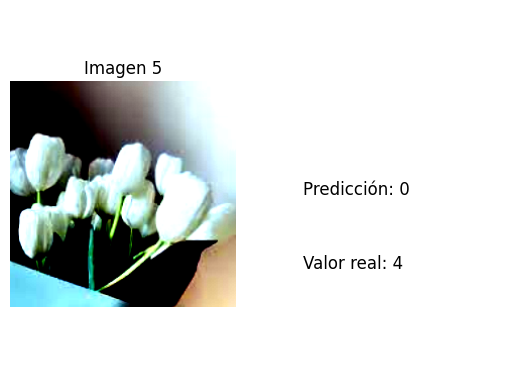

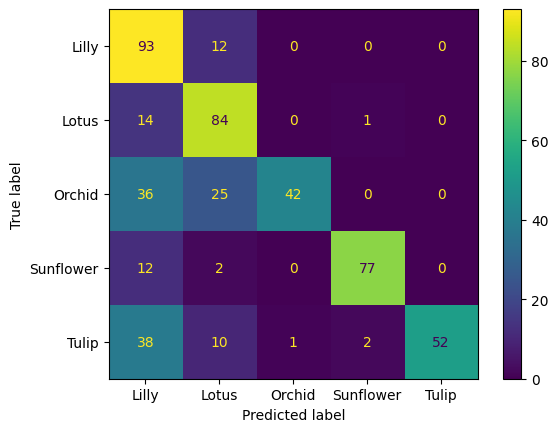

Reporte de Clasificación:
               precision    recall  f1-score   support

       Lilly       0.48      0.89      0.62       105
       Lotus       0.63      0.85      0.72        99
      Orchid       0.98      0.41      0.58       103
   Sunflower       0.96      0.85      0.90        91
       Tulip       1.00      0.50      0.67       103

    accuracy                           0.69       501
   macro avg       0.81      0.70      0.70       501
weighted avg       0.81      0.69      0.69       501



In [ ]:
model_1_testeo = valid(resnet_1,criterion_1)

## Modelo de RES-NET 18 CON REGULARIZACIÓN DE 0.01

Epoch [1/40], Step [10/55], Train Loss: 1.4368
Epoch [1/40], Step [20/55], Train Loss: 1.3319
Epoch [1/40], Step [30/55], Train Loss: 1.2790
Epoch [1/40], Step [40/55], Train Loss: 1.2422
Epoch [1/40], Step [50/55], Train Loss: 1.2178
Epoch [1/40], Train Loss: 1.2101, Train Accuracy: 0.5207, Val Loss: 1.2331, Val Accuracy: 0.5045
Epoch [2/40], Step [10/55], Train Loss: 1.0704
Epoch [2/40], Step [20/55], Train Loss: 1.0491
Epoch [2/40], Step [30/55], Train Loss: 1.0546
Epoch [2/40], Step [40/55], Train Loss: 1.0565
Epoch [2/40], Step [50/55], Train Loss: 1.0528
Epoch [2/40], Train Loss: 1.0461, Train Accuracy: 0.5910, Val Loss: 1.4568, Val Accuracy: 0.4755
Epoch [3/40], Step [10/55], Train Loss: 0.9474
Epoch [3/40], Step [20/55], Train Loss: 0.9765
Epoch [3/40], Step [30/55], Train Loss: 0.9805
Epoch [3/40], Step [40/55], Train Loss: 0.9790
Epoch [3/40], Step [50/55], Train Loss: 0.9697
Epoch [3/40], Train Loss: 0.9698, Train Accuracy: 0.6296, Val Loss: 1.0809, Val Accuracy: 0.6026
Epoc

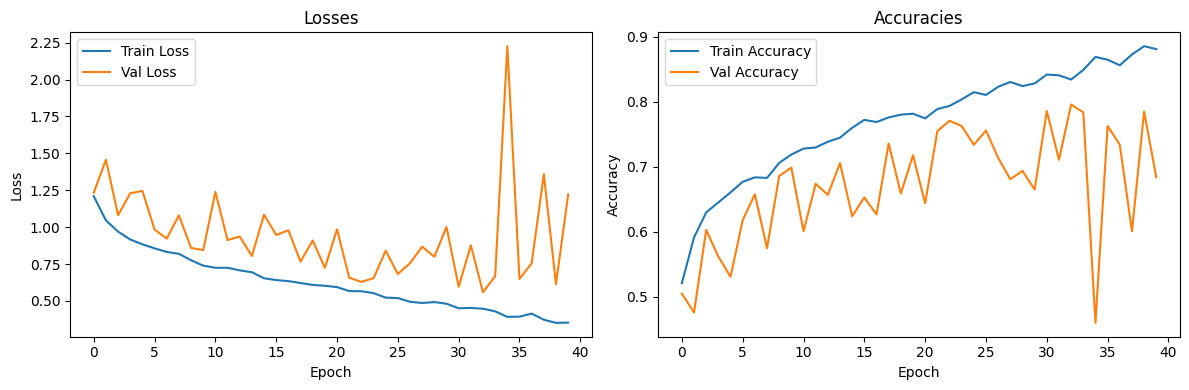

In [ ]:
modelo_2 = train(resnet_2, criterion_2, optimizer_2,train_loader,test_loader,device)

Promedio de pérdida en el conjunto de prueba: 1.1877
Precisión (accuracy) en el conjunto de prueba: 0.6946


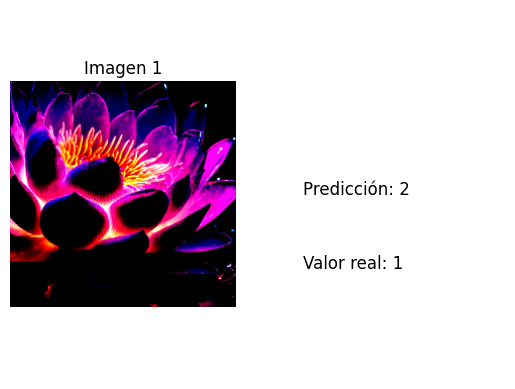

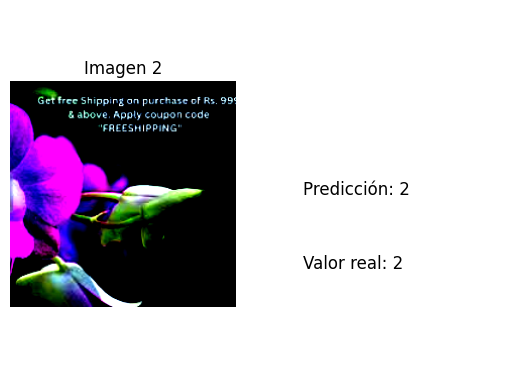

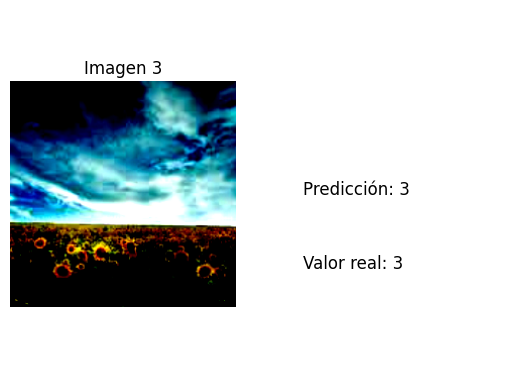

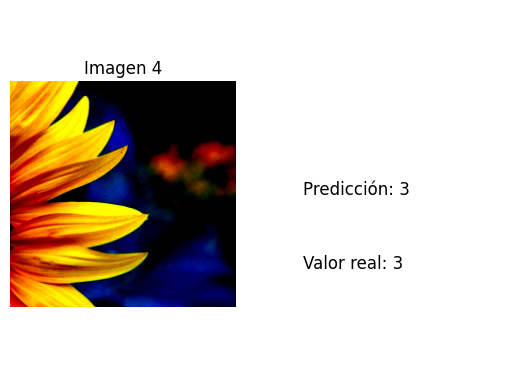

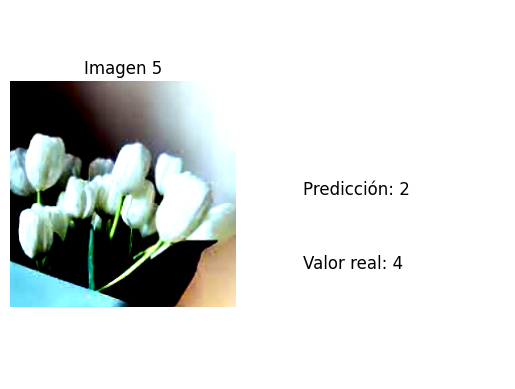

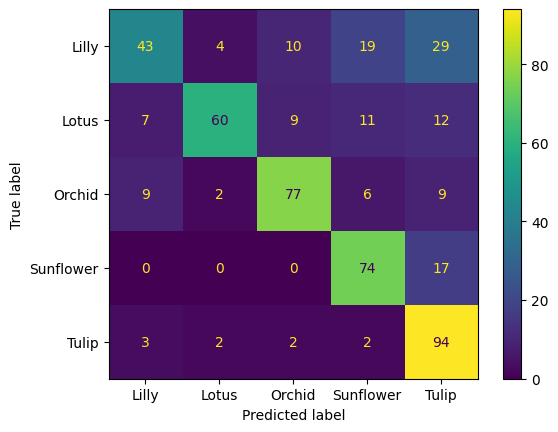

Reporte de Clasificación:
               precision    recall  f1-score   support

       Lilly       0.69      0.41      0.51       105
       Lotus       0.88      0.61      0.72        99
      Orchid       0.79      0.75      0.77       103
   Sunflower       0.66      0.81      0.73        91
       Tulip       0.58      0.91      0.71       103

    accuracy                           0.69       501
   macro avg       0.72      0.70      0.69       501
weighted avg       0.72      0.69      0.69       501



In [ ]:
model_2_testeo = valid(resnet_2,criterion_2)


## Modelo de RES-NET 18 CON REGULARIZACIÓN DE 0.1

Epoch [1/40], Step [10/55], Train Loss: 1.3969
Epoch [1/40], Step [20/55], Train Loss: 1.2977
Epoch [1/40], Step [30/55], Train Loss: 1.2511
Epoch [1/40], Step [40/55], Train Loss: 1.2135
Epoch [1/40], Step [50/55], Train Loss: 1.2033
Epoch [1/40], Train Loss: 1.1917, Train Accuracy: 0.5250, Val Loss: 1.1355, Val Accuracy: 0.5536
Epoch [2/40], Step [10/55], Train Loss: 1.0260
Epoch [2/40], Step [20/55], Train Loss: 1.0667
Epoch [2/40], Step [30/55], Train Loss: 1.0508
Epoch [2/40], Step [40/55], Train Loss: 1.0611
Epoch [2/40], Step [50/55], Train Loss: 1.0593
Epoch [2/40], Train Loss: 1.0529, Train Accuracy: 0.5973, Val Loss: 1.0932, Val Accuracy: 0.5485
Epoch [3/40], Step [10/55], Train Loss: 1.0078
Epoch [3/40], Step [20/55], Train Loss: 0.9985
Epoch [3/40], Step [30/55], Train Loss: 0.9919
Epoch [3/40], Step [40/55], Train Loss: 0.9966
Epoch [3/40], Step [50/55], Train Loss: 0.9977
Epoch [3/40], Train Loss: 0.9943, Train Accuracy: 0.6136, Val Loss: 1.0595, Val Accuracy: 0.5726
Epoc

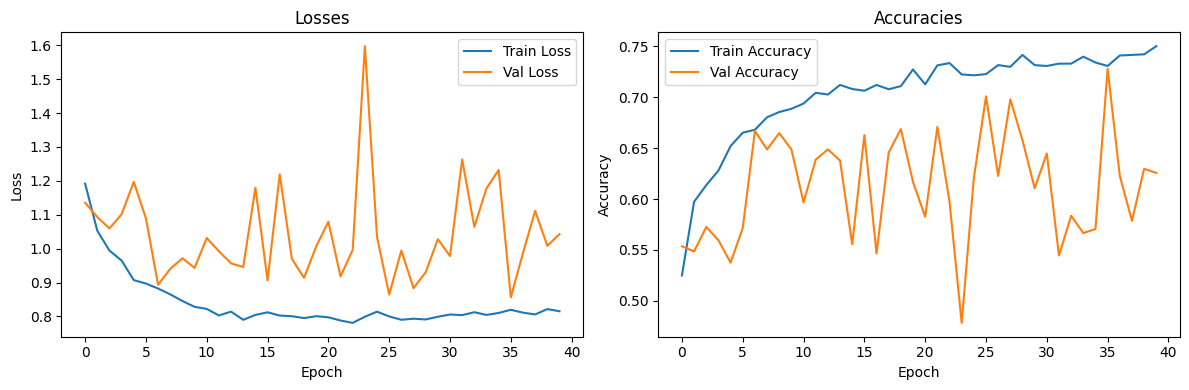

In [ ]:
modelo_3 = train(resnet_3, criterion_3, optimizer_3, train_loader,test_loader,device)

Promedio de pérdida en el conjunto de prueba: 0.9983
Precisión (accuracy) en el conjunto de prueba: 0.6507


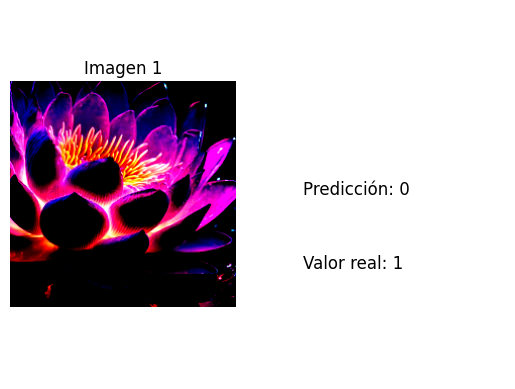

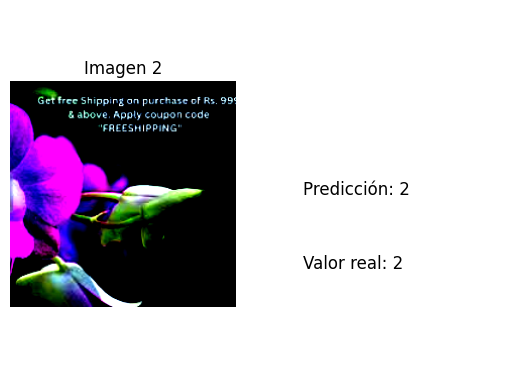

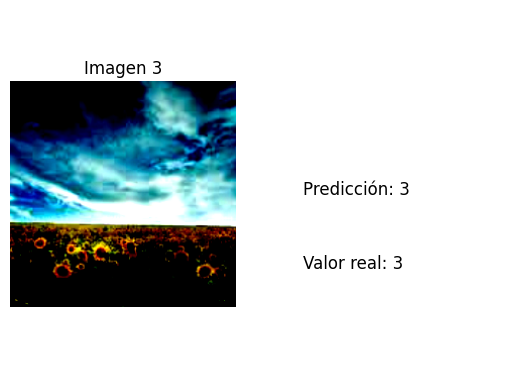

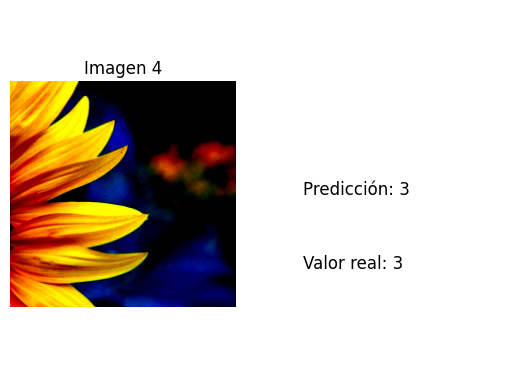

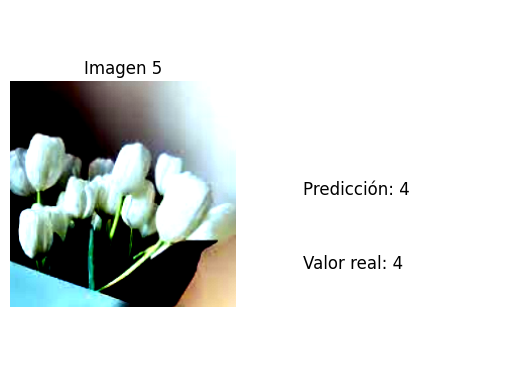

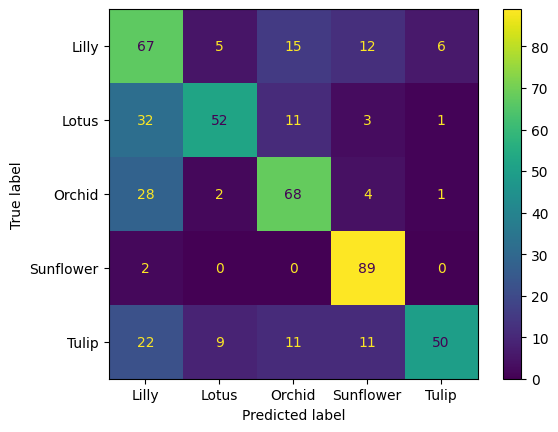

Reporte de Clasificación:
               precision    recall  f1-score   support

       Lilly       0.44      0.64      0.52       105
       Lotus       0.76      0.53      0.62        99
      Orchid       0.65      0.66      0.65       103
   Sunflower       0.75      0.98      0.85        91
       Tulip       0.86      0.49      0.62       103

    accuracy                           0.65       501
   macro avg       0.69      0.66      0.65       501
weighted avg       0.69      0.65      0.65       501



In [ ]:
model_3_testeo = valid(resnet_3,criterion_3)

## Modelo transfer Learning

In [ ]:
#Pegue y ejecute aquí su código para el punto 3.2

model_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1 )
model_resnet = model_resnet.to(device)

for param in model_resnet.parameters(): #Se congelan las capas para que no sea tan alto el coste computacional
    param.requires_grad = False

num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 5).to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.9MB/s]


In [ ]:
criterion_tl = nn.CrossEntropyLoss().to(device)
optimizer_tl = torch.optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

Epoch [1/40], Step [10/55], Train Loss: 1.5951
Epoch [1/40], Step [20/55], Train Loss: 1.4931
Epoch [1/40], Step [30/55], Train Loss: 1.3877
Epoch [1/40], Step [40/55], Train Loss: 1.2926
Epoch [1/40], Step [50/55], Train Loss: 1.2087
Epoch [1/40], Train Loss: 1.1719, Train Accuracy: 0.5730, Val Loss: 0.7700, Val Accuracy: 0.7988
Epoch [2/40], Step [10/55], Train Loss: 0.7490
Epoch [2/40], Step [20/55], Train Loss: 0.7226
Epoch [2/40], Step [30/55], Train Loss: 0.7060
Epoch [2/40], Step [40/55], Train Loss: 0.6952
Epoch [2/40], Step [50/55], Train Loss: 0.6821
Epoch [2/40], Train Loss: 0.6766, Train Accuracy: 0.8094, Val Loss: 0.5838, Val Accuracy: 0.8278
Epoch [3/40], Step [10/55], Train Loss: 0.6234
Epoch [3/40], Step [20/55], Train Loss: 0.5839
Epoch [3/40], Step [30/55], Train Loss: 0.5844
Epoch [3/40], Step [40/55], Train Loss: 0.5694
Epoch [3/40], Step [50/55], Train Loss: 0.5612
Epoch [3/40], Train Loss: 0.5548, Train Accuracy: 0.8374, Val Loss: 0.5008, Val Accuracy: 0.8559
Epoc

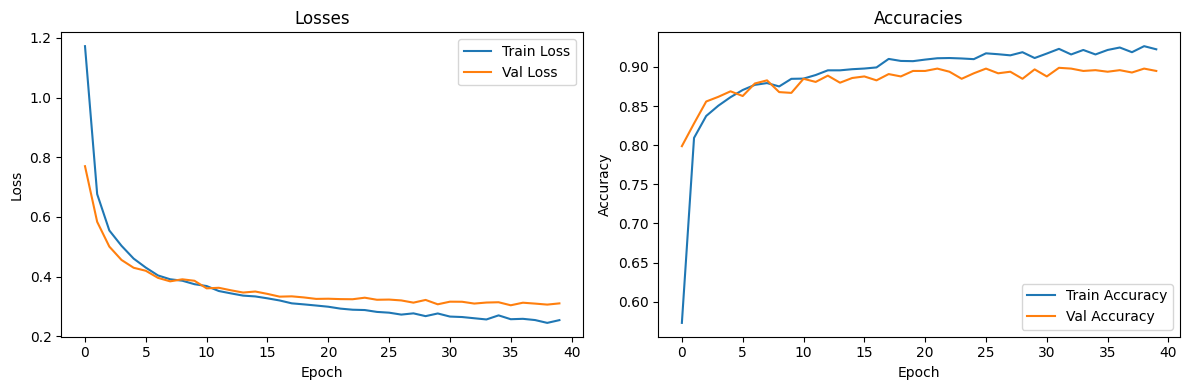

In [ ]:
transfer_learning = train(model_resnet, criterion_tl, optimizer_tl, train_loader,test_loader,device)

Promedio de pérdida en el conjunto de prueba: 0.3603
Precisión (accuracy) en el conjunto de prueba: 0.8703


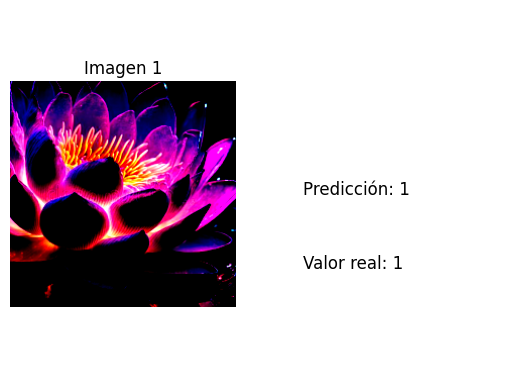

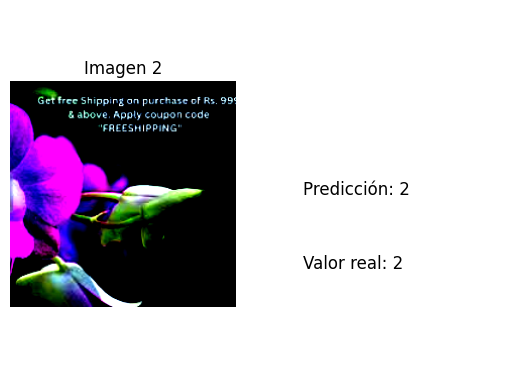

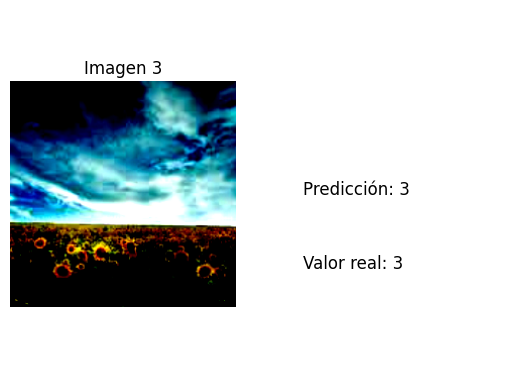

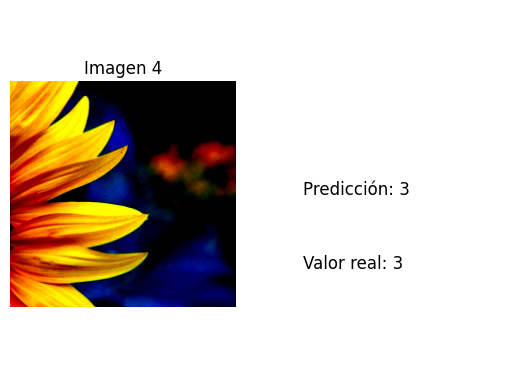

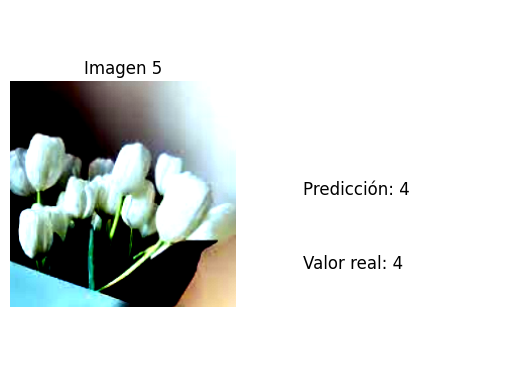

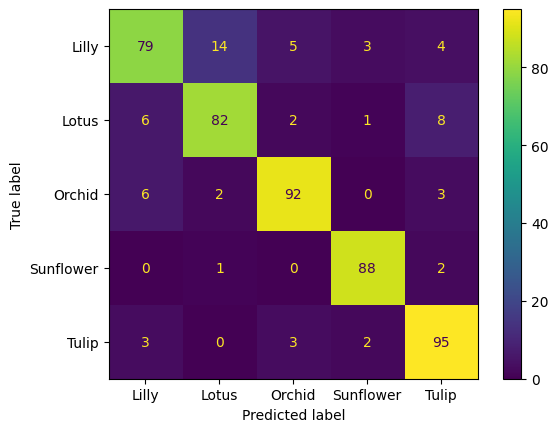

Reporte de Clasificación:
               precision    recall  f1-score   support

       Lilly       0.84      0.75      0.79       105
       Lotus       0.83      0.83      0.83        99
      Orchid       0.90      0.89      0.90       103
   Sunflower       0.94      0.97      0.95        91
       Tulip       0.85      0.92      0.88       103

    accuracy                           0.87       501
   macro avg       0.87      0.87      0.87       501
weighted avg       0.87      0.87      0.87       501



In [ ]:
transfer_testeo = valid(model_resnet,criterion_tl)

## (0.25) Edite aqui el analisis del punto 3.3


### Modelo sin regularización

>
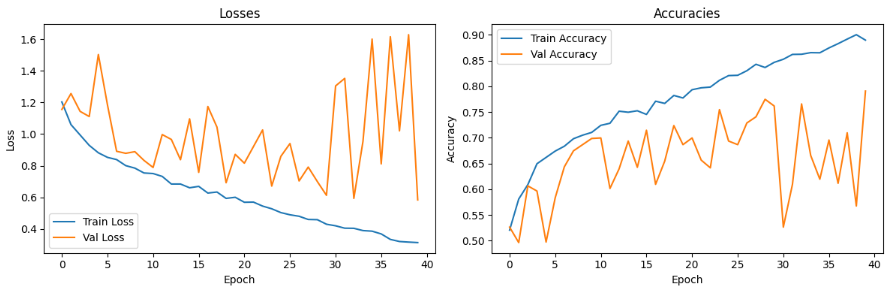
>
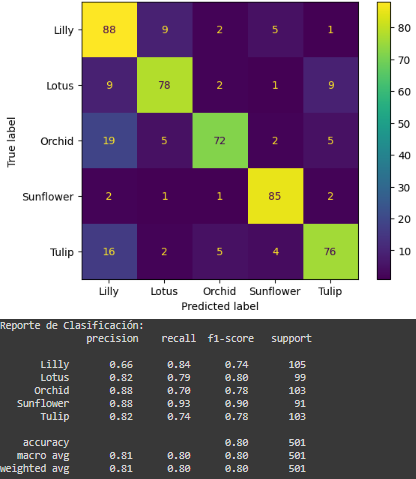
>
### Modelo con regularizacion de 0.001
>
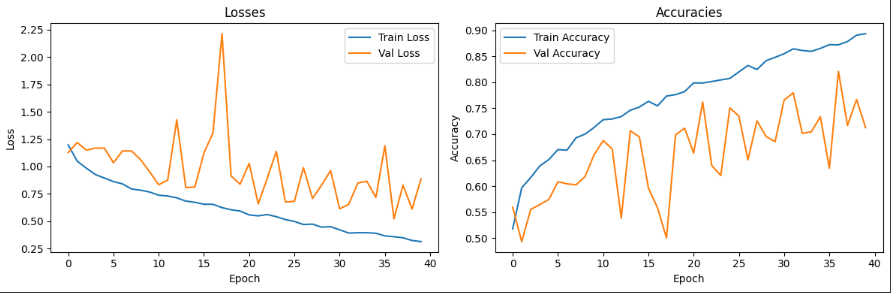
>
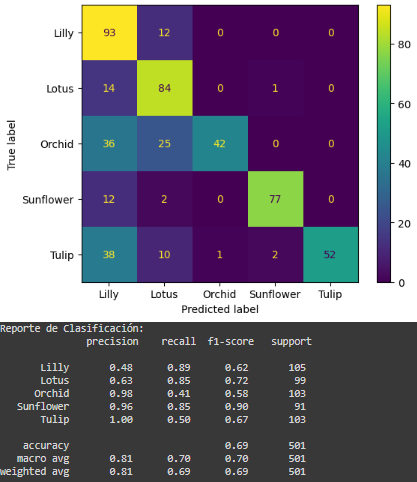
>
### Modelo regularizacion 0.01
>
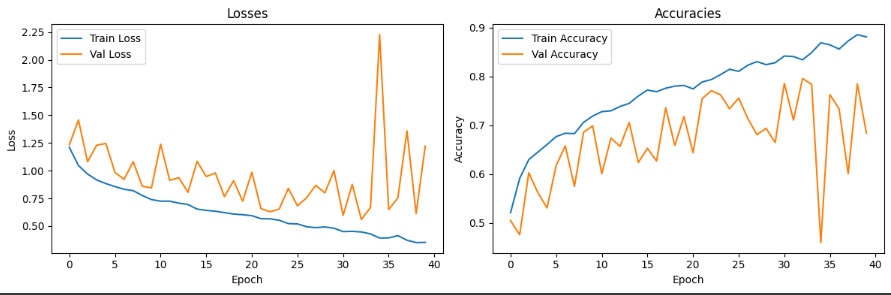
>
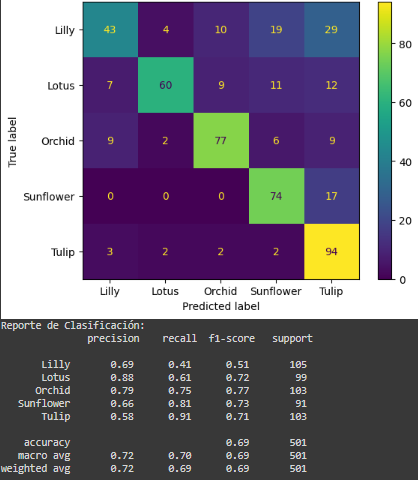
>
### Modelo regularizacion 0.1
>
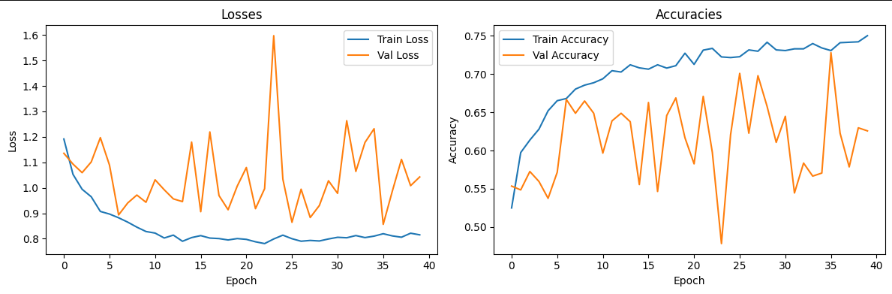
>
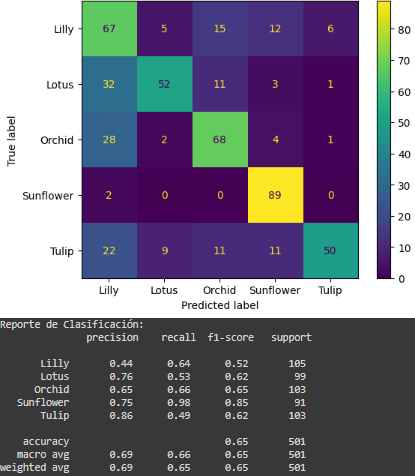
>
### Model TransferLearning
>
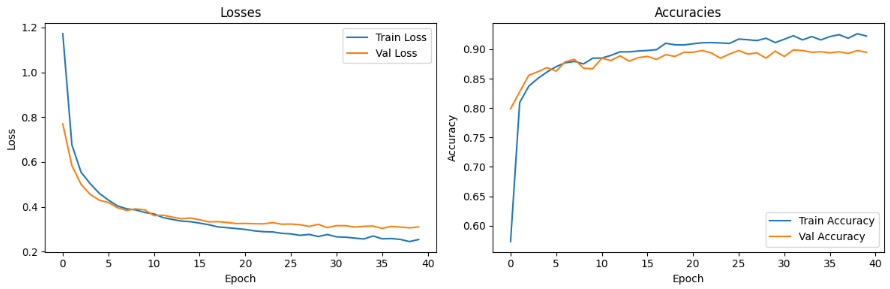
>
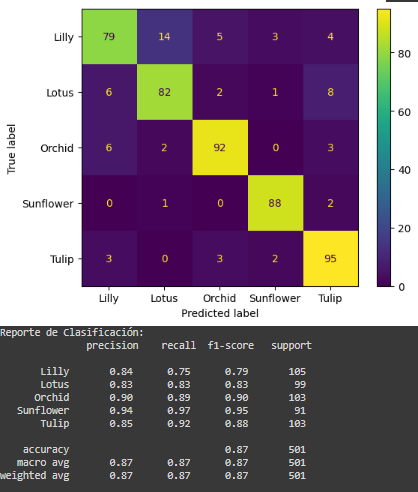

**Analisis:**
Para las validaciones se obtuvieron estos resultados:

- Cantidad de valores predichos correctamente (TP) por cada modelo teniendo en cuenta que:
  - Para la clase Lilly se tienen 105 datos.
  - Para la clase Lotus se tienen 99 datos.
  - Para la clase Orchid se tienen 101 datos.
  - Para la clase Sunflower se tienen 93 datos.
  - Para la clase Tulip se tienen 103 datos.

- **Modelo sin regularizacion:**
  * Promedio de pérdida en el conjunto de prueba: 0.5833
  * Precisión (accuracy) en el conjunto de prueba: 0.7964

  * Los valores de las métricas obtenidas en el f1-score para las clases del modelo sin regularización fueron las siguientes:
    * Clase Lilly tuvo en f1-score de **79%**, en donde el modelo logró predecir correctamente **88 datos**.
    * Clase Lotus tuvo un f1-score de **80%**, en donde el modelo logró predecir correctamente **78 datos**.
    * Clase Orchid tuvo un f1-score de **78%**, en donde el modelo logró predecir correctamente **72 datos**.
    * Clase Sunflower tuvo un f1-score de **90%**, en donde el modelo logró predecir correctamente **85 datos**.
    * Clase Tulip tuvo un f1-score de **78%**, en donde el modelo logró predecir correctamente **76 datos**.

- **Modelo con regularizacion de 0.001:**
  * Promedio de pérdida en el conjunto de prueba: 0.9054
  * Precisión (accuracy) en el conjunto de prueba: 0.6946

  * Los valores de las métricas obtenidas en el f1-score para las clases del modelo sin regularización fueron las siguientes:
    * Clase Lilly tuvo en f1-score de **62%**, en donde el modelo logró predecir correctamente **93 datos**.
    * Clase Lotus tuvo un f1-score de **72%**, en donde el modelo logró predecir correctamente **84 datos**.
    * Clase Orchid tuvo un f1-score de **58%**, en donde el modelo logró predecir correctamente **42 datos**.
    * Clase Sunflower tuvo un f1-score de **90%**, en donde el modelo logró predecir correctamente **77 datos**.
    * Clase Tulip tuvo un f1-score de **50%**, en donde el modelo logró predecir correctamente **52 datos**.

- **Modelo con regularizacion de 0.01:**
  * Promedio de pérdida en el conjunto de prueba: 1.1877
  * Precisión (accuracy) en el conjunto de prueba: 0.6946

  * Los valores de las métricas obtenidas en el f1-score para las clases del modelo sin regularización fueron las siguientes:
    * Clase Lilly tuvo en f1-score de **51%**, en donde el modelo logró predecir correctamente **43 datos**.
    * Clase Lotus tuvo un f1-score de **72%**, en donde el modelo logró predecir correctamente **60 datos**.
    * Clase Orchid tuvo un f1-score de **77%**, en donde el modelo logró predecir correctamente **77 datos**.
    * Clase Sunflower tuvo un f1-score de **73%**, en donde el modelo logró predecir correctamente **74 datos**.
    * Clase Tulip tuvo un f1-score de **71%**, en donde el modelo logró predecir correctamente **94 datos**.

- **Modelo con regularizacion de 0.1:**
  * Promedio de pérdida en el conjunto de prueba: 0.9983
  * Precisión (accuracy) en el conjunto de prueba: 0.6507

  * Los valores de las métricas obtenidas en el f1-score para las clases del modelo sin regularización fueron las siguientes:
    * Clase Lilly tuvo en f1-score de **52%**, en donde el modelo logró predecir correctamente **67 datos**.
    * Clase Lotus tuvo un f1-score de **62%**, en donde el modelo logró predecir correctamente **52 datos**.
    * Clase Orchid tuvo un f1-score de **65%**, en donde el modelo logró predecir correctamente **68 datos**.
    * Clase Sunflower tuvo un f1-score de **85%**, en donde el modelo logró predecir correctamente **89 datos**.
    * Clase Tulip tuvo un f1-score de **62%**, en donde el modelo logró predecir correctamente **50 datos**.

- **Modelo Transfer Learning:**
  * Promedio de pérdida en el conjunto de prueba: 0.3603
  * Precisión (accuracy) en el conjunto de prueba: 0.8703

  * Los valores de las métricas obtenidas en el f1-score para las clases del modelo sin regularización fueron las siguientes:
    * Clase Lilly tuvo en f1-score de **79%**, en donde el modelo logró predecir correctamente **79 datos**.
    * Clase Lotus tuvo un f1-score de **83%**, en donde el modelo logró predecir correctamente **82 datos**.
    * Clase Orchid tuvo un f1-score de **90%**, en donde el modelo logró predecir correctamente **92 datos**.
    * Clase Sunflower tuvo un f1-score de **95%**, en donde el modelo logró predecir correctamente **88 datos**.
    * Clase Tulip tuvo un f1-score de **88%**, en donde el modelo logró predecir correctamente **95 datos**.


### **Mejor Modelo**
### El mejor modelo según el análisis visto es claramente el modelo con Transfer Learning por sus altas predicciones correctas en la clasificación de cada clase, además en sus gráficas de pérdida y precisión se visualiza un gran entrenamiento por parte de este modelo y sus métricas de f1-score demuestran el gran desempeño de este modelo para clasificar las 5 clases, clasificando de mejor manera de manera descendente (de mayor a menor) en las clases Sunflower, Orchid, Tulip, Lotus, Lilly.

### El segundo modelo que puede considerar bueno para clasificar las 5 clases, es el modelo sin regularizador, obteniendo valores aceptables para ser considerados como clasificadores de cada clase, con una aceptable clasificación de cada clase entre los predichos y los reales.

# <font color='red'>Punto 4 (1.0). Comprendiendo mejor su Clasificador</font>.

A partir de la lectura juiciosa de este enlace: [VISUALIZING FEATURE MAPS](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/).

Realice una comparación visual de las diferentes capas convolucionales (entendiendo que estas, son las que producen los diferentes feature maps).<font color='red'>[Nota: Para esta parte, utilice el conjunto de datos de TEST]</font>.

Acompañe esta comparación visual con un párrafo donde muestre su análisis al respecto.


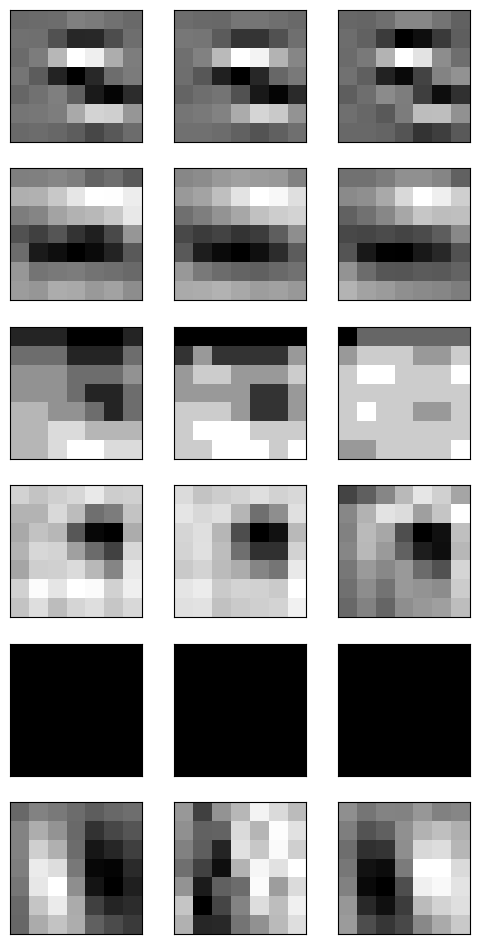

In [ ]:
# Obtener los filtros y biases del primer layer de convolución
filters = model_resnet.conv1.weight.data

# Normalizar los valores de los filtros a un rango de 0-1 para visualizarlos
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Número de filtros a visualizar
n_filters = 6
# Número de canales de color (3 para RGB)
n_channels = 3

fig, axes = plt.subplots(n_filters, n_channels, figsize=(n_channels*2, n_filters*2))

for i in range(n_filters):
    # Obtener el filtro
    f = filters[i]
    for j in range(n_channels):
        ax = axes[i, j]
        ax.set_xticks([])
        ax.set_yticks([])
        # Visualizar el filtro para cada canal
        ax.imshow(f[j, :, :].cpu().numpy(), cmap='gray')

plt.show()



Edite aquí su analisis.


La finalidad del mapa de características es entender los patrones que detecta la red en cada capa, además de que permite identificar problemas, como filtros que no están aprendiendo o que están detectando patrones irrelevantes y es muy relevante para entender los modelos de CNN (Res-Net18), proporcionando una visión más clara de cómo toman decisiones.

Los mapas de características desde bordes y contornos simples, pasan por texturas intermedias, hasta llegar a patrones específicos y complejos, reflejando cómo la red convolucional construye una comprensión jerárquica de las imágenes de las 5 clases de flores.

Podemos ver en cada fila como realiza los mapas de características en los que se pueden llegar a perder la capacidad de interpretar estos mapas por su profundidad. Tenemos entonces:

1. **Primera, segunda y tercera fila**: Los mapas de características en la primera fila se observa como detecta patrones de bordes y contornos. Estas activaciones indican que está detectando las estructuras básicas de la imagen, como los contornos de los pétalos de las flores. A medida que avanzan las capas, los mapas de características comienzan a capturar texturas y patrones más complejos. En estas capas, se observan activaciones más difusas y variadas, que podrían representar diferentes texturas de los pétalos, variaciones en el color o iluminación de las imágenes. En estas capas la red combina los bordes y contornos detectados en la primera fila para identificar mayor detalle en las imágenes, como texturas.

  **Cuarta fila**: Los mapas aquí muestran activaciones a partes distintivas de las flores, como la disposición de los pétalos o el centro de la flor vistos en color negro. En esta cuarta fila se encuentra reconociendo patrones más cruciales para la clasificación correcta de las flores a partir de su centro y pétalos que rodean el centro (color gris).

  **Quinta y sexta fila**: En la quinta fila se ve activaciones completamente negras, esto se puede deber a que no encontró características relevantes o cruciales en esa parte de la imagen de las anteriores filas. Mientras que en la sexta fila los mapas muestran activaciones con patrones muy definidos que corresponden a características distintivas, como el centro de la flor o combinaciones específicas de texturas y bordes, como una mezcla de las primeras cuatra filas.